### Let's explore churn rate among taxi drivers in taxi app. Define group prone to leave from the app

#### Import libs and have a look on the data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [2]:
df = pd.read_csv('churn.csv', parse_dates = ['last_trip_date'])
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [3]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [9]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [11]:
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date                       object
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
dtype: object

In [5]:
df['days_since_last_trip'] = df.last_trip_date.max() - df['last_trip_date']

In [6]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [24]:
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date                       object
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
days_since_last_trip               int64
dtype: object

#### Define churn and not churn categories by city

In [7]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


In [41]:
contingency_table = pd.crosstab(df.city, df.churn)
contingency_table

churn,churn,not_churn
city,,
Astapor,12306,4228
King's Landing,3767,6363
Winterfell,15123,8213


In [28]:
ss.chi2_contingency(contingency_table)

(3821.5510225559638,
 0.0,
 2,
 array([[10315.89328,  6218.10672],
        [ 6320.3096 ,  3809.6904 ],
        [14559.79712,  8776.20288]]))

In [42]:
df_per_city = df.groupby('city').agg({'trips_in_first_30_days': 'sum'})
df_per_city

,trips_in_first_30_days
city,
Astapor,32219
King's Landing,24957
Winterfell,56734


#### Check the normality of distributions with the Shapiro-Wilk test 

In [34]:
ss.shapiro(df[df.city == 'Astapor'].trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.6078083515167236, pvalue=1.0509738482436128e-42)

In [36]:
ss.shapiro(df[df.city == 'King\'s Landing'].trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.613675057888031, pvalue=1.753024378870346e-42)

In [38]:
ss.shapiro(df[df.city == 'Winterfell'].trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.5492562055587769, pvalue=8.407790785948902e-45)

#### Distributions are not normal. Apply the Kruskal-Wallis H-test for independent samples

In [47]:
ss.kruskal(df[df.city == 'Astapor'].trips_in_first_30_days, df[df.city == 'King\'s Landing'].trips_in_first_30_days, df[df.city == 'Winterfell'].trips_in_first_30_days)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

#### Statistically significant result in 30-days period detected

#### Assume that main trouble is in mobile platform of driver's devices. Thus they leave the app.

In [8]:
pd.crosstab(df.churn, df.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


#### Apply Chi-square test of independence of variables in a contingency table

In [10]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(df.churn, df.phone))

In [11]:
stat, p

(2558.394212267425, 0.0)

#### Reject the null hypothesis. Drivers with Android devices have left the app statistically more often then drivers with IOS. The trouble in Android update.

#### Now assume that churn rate associated with 30-days period activity

In [49]:
df[['days_since_last_trip', 'churn', 'trips_in_first_30_days']]

,days_since_last_trip,churn,trips_in_first_30_days
0,14,not_churn,4
1,57,churn,0
2,175,churn,3
3,2,not_churn,9
4,108,churn,14
...,...,...,...
49995,26,not_churn,0
49996,157,churn,1
49997,40,churn,0
49998,167,churn,2


#### Check the distribution of trips_in_first_30_days sample

In [52]:
ss.shapiro(df.trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.6009641885757446, pvalue=5.829401611591239e-43)

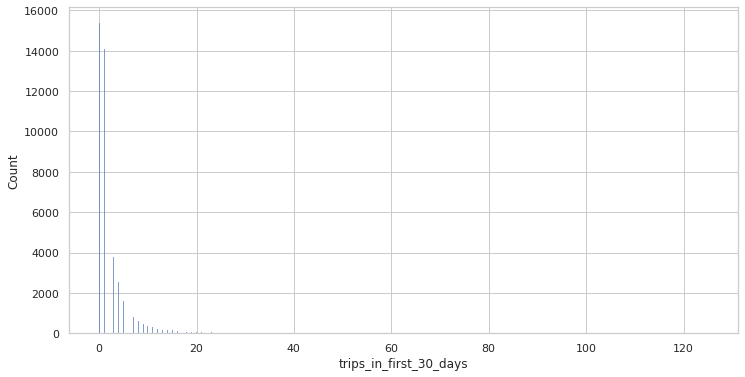

In [53]:
sns.histplot(df.trips_in_first_30_days)

#### Distribution is not normal. Apply the Mann-Whitney U rank test on two independent samples

In [54]:
ss.mannwhitneyu(df.query('churn == "not_churn"').trips_in_first_30_days, df.query('churn == "churn"').trips_in_first_30_days)

MannwhitneyuResult(statistic=351842132.0, pvalue=0.0)

#### Statistically significant result detected. Therefore we have significant differences, drivers who have left the app actually were less active 

In [55]:
df.groupby('churn').agg({'trips_in_first_30_days': 'sum'})

,trips_in_first_30_days
churn,
churn,51738
not_churn,62172
